# Performance assessment for the RLS algorithm

The code in this notebook is an offline version of the RLS algorithm,
used to produce the results of the performance section of the report.

For more information about the actual implementation of the RLS algorithm or data generation
methodology, please refer to the other notebooks.

In [23]:
import numpy as np
from numpy.polynomial.polynomial import polyfit
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [2]:
class NormalWishart:
    """Normal-Wishart distribution.
    
    Attributes:
        _mu0 (:obj:`np.ndarray`): location vector.
        _D (int): Number of components.
        _lambda (float): positive-only scalar.
        _W (:obj:`np.ndarray`): positive definite scale matrix.
        _nu (int): number of degrees of freedom.
        _n (int): sample size.
        _0 (:obj:`np.ndarray`): pre-allocated vector of zeros.
    """
    
    def __init__(self, mu0, _lambda, W, nu, n):
        self._mu0 = np.asarray(mu0)
        self._D = self._mu0.shape[0]
        self._lambda = _lambda
        self._W = np.asarray(W)
        self._nu = nu
        self._n = n
        self._0 = np.zeros(self._nu)
        # Make sure that degrees of freedom are sufficient
        # and that the dimensionality if the scale matrix is correct.
        assert((self._nu > self._D - 1) and (len(W) == self._nu))
    
    def sample(self):
        """Randomly generates a sample of `self._n` observations.
        
        returns:
            :obj:`np.ndarray`: a random mean vector.
            :obj:`np.ndarray`: a random precision matrix.
        """
        # Randomly samples the mean vector
        mu = np.random.multivariate_normal(self._mu0, self._W)
        
        # Randomly samples the precision matrix
        G = np.random.multivariate_normal(self._0, self._W, size=self._n)
        S = np.dot(G.T, G)
        return mu, S

In [3]:
class Generator:
    """Data generator.
    
    Attributes:
        _n_inputs (int): Number of explanatory variables.
        _n_outputs (int): Number of explained variables.
        _latent_dim (int): Latent dimension, represented by the
            number of Gaussian observations to draw for
            estimating the precision matrix.
        _beta (:obj:`np.ndarray`): Variable weights.
    """
    
    def __init__(self, n_inputs, n_outputs, latent_dim=15):
        self._counter = 0
        self._n_inputs = n_inputs
        self._n_outputs = n_outputs
        self._latent_dim = latent_dim
        
        # Initializes NW distribution with the identity
        # as scale matrix and a zero vector as location vector.
        W = np.eye(self._n_inputs)
        mu0 = np.zeros(self._n_inputs)
        nu = self._n_inputs
        nw = NormalWishart(mu0, 1., W, nu, self._latent_dim)
        
        # Lambda is a random precision matrix,
        # and needs to be inverted in order to obtain
        # a covariance matrix.
        mu, Lambda = nw.sample()
        Sigma = np.linalg.inv(Lambda)
        
        # Randomly initializes the variable weights
        self._beta = np.random.multivariate_normal(mu, Sigma, self._n_outputs)
    
    def sample(self, sample_size=1, wscale=0.1):
        """Draw random samples from a multivariate Gaussian distribution.
        
        Parameters:
            sample_size (int): Number of observations to draw.
        
        Returns:
            :obj:`np.ndarray`: Array of shape (`sample_size`, `self._n_inputs`)
                containing random values for the explanatory variables.
            :obj:`np.ndarray`: Array of shape (`sample_size`, `self._n_outputs`)
                containing Random values for the explained variables.
            :obj:`np.ndarray`: Array of length `sample_size` containing the unique
                identifiers of generated samples.
        """
        # Generates unique identifiers
        counters = np.arange(self._counter, self._counter + sample_size)
        self._counter += sample_size
        
        # Samples explanatory variables
        X = np.random.rand(sample_size, self._n_inputs)
        
        # Samples random noise
        w = np.random.normal(0, wscale, size=self._n_outputs)
        
        # Computes outputs
        y = np.dot(X, self._beta.T) + w
        return np.squeeze(X), np.squeeze(y), counters
    
    @property
    def counter(self):
        """Returns current value for the sample counter.
        
        Returns:
            int: Identifier of the next sample to be generated.
        """
        return self._counter

In [4]:
class MultivariateLinearModel:
    """Multivariate linear model, trainable with the
    recursive least squares (RLS) algorithm.
    
    Attributes:
        _n_inputs (int): Number of explanatory variables.
        _n_outputs (int): Number of explained variables.
        TODO
    """
    
    def __init__(self, n_inputs, n_outputs, a=10., nu=1.):
        self._n_inputs = n_inputs
        self._n_outputs = n_outputs
        self._a = a
        self._nu = nu # Forgetting factor
        self._V = np.eye(self._n_inputs) * self._a
        self._beta = np.zeros((self._n_inputs, self._n_outputs))

    def update(self, new_values, state): 
        ## RLS update function
        ## Only update with first value of RDD. You should transofrm new_values to array, and update models for all values 
        if (len(new_values) > 0):

            key = state[0]
            yx = new_values
            #key = new_values[0][0]
            #yx = new_values[0][1]
            
            i = yx[0]
            y = yx[1:self._n_outputs+1]
            x = yx[self._n_outputs+1:]

            # Retrieve variables from state
            sse = state[1]  ## sum of squared errors
            N = state[2]   ## number of treated samples
            
            err = y - np.dot(x, self._beta)
            sse = (N * sse + np.mean(err ** 2.)) / (N + 1.)
            
            self._V -= (np.dot(self._V, np.dot(x, np.dot(x, self._V))) / (1. + np.dot(x, np.dot(self._V, x))))
            self._V /= self._nu
            
            alpha = np.dot(self._V, x)
            self._beta += np.outer(alpha, err)

            return (key, sse, N + 1)

        else:
            return state

In [5]:
def moving_average(signal, wsize=24):
    """Computes moving average on a signal.
    If `overlapping` is True, then the size of the input
    signal is preserved. Otherwise, only the centers
    of non-overlapping windows are returned.

    Parameters:
        signal (:obj:`np.ndarray`): Input signal
        wsize (int): Size of the running window.

    Returns:
        :obj:`np.ndarray`: Filtered signal.
    """
    means = np.cumsum(signal, dtype=np.float)
    offset = wsize // 2
    diff = means[wsize:] - means[:-wsize]
    means[offset:offset+len(diff)] = diff[:] / wsize

    # Keep borders more or less as such
    #means[:offset] = (signal[:offset] + np.mean(signal[:offset])) / 2.0
    #means[offset+len(diff):] = (signal[offset+len(diff):] + np.mean(signal[offset+len(diff):])) / 2.0
    return means[offset:offset+len(diff)]

## Convergence as a function of the forgetting factor

In [6]:
n = 10 # Number of inputs
m = 8 # Number of outputs

n_models = 6

gen = Generator(n, m)

nus = np.linspace(0.5, 1.0, n_models)
models = [MultivariateLinearModel(n, m, nu=nu) for nu in nus]

states = [('mod%i' % (i + 1), 0, 0) for i in range(n_models)]

errors = [list() for _ in range(n_models)]
frob = [list() for _ in range(n_models)]
while True:
    x, y, counters = gen.sample()
    values = np.concatenate((counters, y, x))
    
    for i in range(n_models):
        state = models[i].update(values, states[i])
        errors[i].append(state[1])
        frob[i].append(np.sqrt((models[i]._beta - gen._beta.T) ** 2.).sum())
    
    if gen.counter >= 3000:
        break
    

In [7]:
PALETTE = list(reversed(['black', '#36213E', '#554971', '#63768D', '#8AC6D0', '#B8F3FF']))
PALETTE2 = ['#CF9893', '#BC7C9C', '#A96DA3', '#7A5980', '#3B3B58', 'black']
PALETTE3 = ['#87BCDE', '#805E73', '#4E4D5C', '#2D4654', '#243B4A', 'black']
PALETTE4 = list(reversed(['black', '#395E66', '#387D7A', '#32936F', '#26A96C', '#2BC016']))
PALETTE5 = list(reversed(['black', '#550527', '#688E26', '#FAA613', '#F44708', '#A10702']))

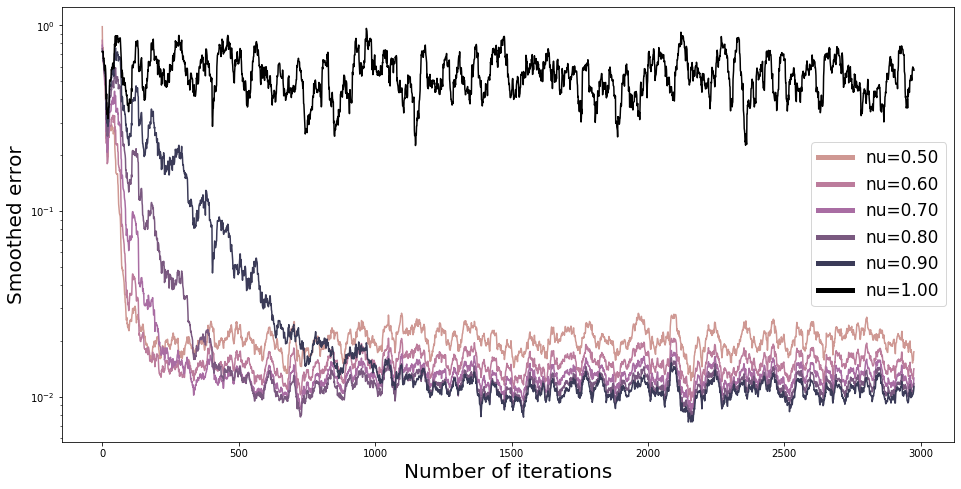

In [8]:
plt.rcParams["figure.figsize"] = (16, 8)

LABEL_FONT_SIZE = 20

for i in range(n_models):
    ys = moving_average(errors[i])
    plt.plot(ys, label='nu={0:.2f}'.format(nus[i]), color=PALETTE2[i])
plt.ylabel('Smoothed error', fontsize=LABEL_FONT_SIZE)
plt.xlabel('Number of iterations', fontsize=LABEL_FONT_SIZE)
plt.yscale('log')
leg = plt.legend(prop={'size': 17})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.savefig('report/imgs/convergence.png')
plt.show()

## Frobenius norm as a function of the forgetting factor

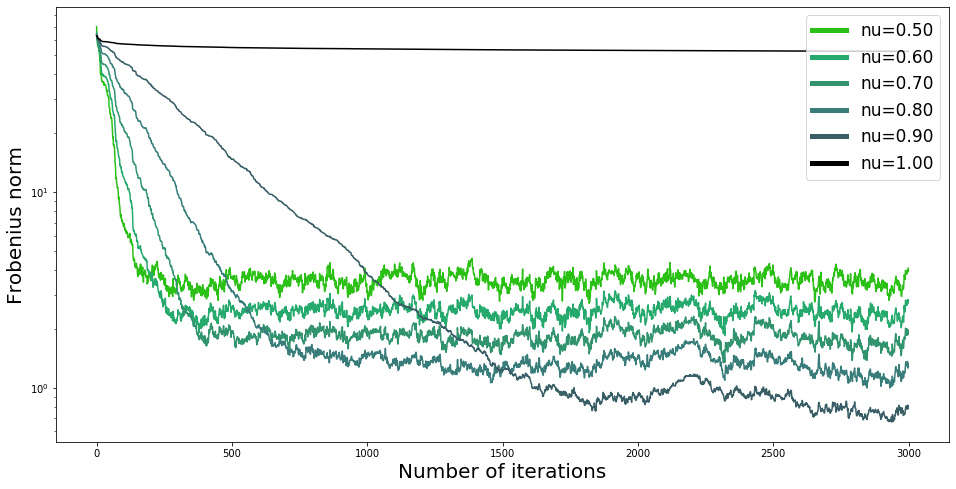

In [9]:
plt.rcParams["figure.figsize"] = (16, 8)

colors = []

for i in range(n_models):
    ys = frob[i]
    plt.plot(ys, label='nu={0:.2f}'.format(nus[i]), color=PALETTE4[i])
plt.ylabel('Frobenius norm', fontsize=LABEL_FONT_SIZE)
plt.xlabel('Number of iterations', fontsize=LABEL_FONT_SIZE)
plt.yscale('log')
leg = plt.legend(prop={'size': 17})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.savefig('report/imgs/frobenius.png')
plt.show()

## Frobenius norm as a function of the noise level

In [19]:
n = 10 # Number of inputs
m = 8 # Number of outputs

n_models = 1000

gen = [Generator(n, m) for _ in range(n_models)]

models = [MultivariateLinearModel(n, m, nu=0.9) for i in range(n_models)]

states = [('mod%i' % (i + 1), 0, 0) for i in range(n_models)]

errors = [list() for _ in range(n_models)]
frob = [list() for _ in range(n_models)]
for i in range(n_models):
    while True:
        x, y, counters = gen[i].sample(wscale=i*0.1)
        values = np.concatenate((counters, y, x))

        state = models[i].update(values, states[i])
        errors[i].append(state[1])
        frob[i].append(np.sqrt((models[i]._beta - gen[i]._beta.T) ** 2.).sum())

        if gen[i].counter >= 3000:
            break

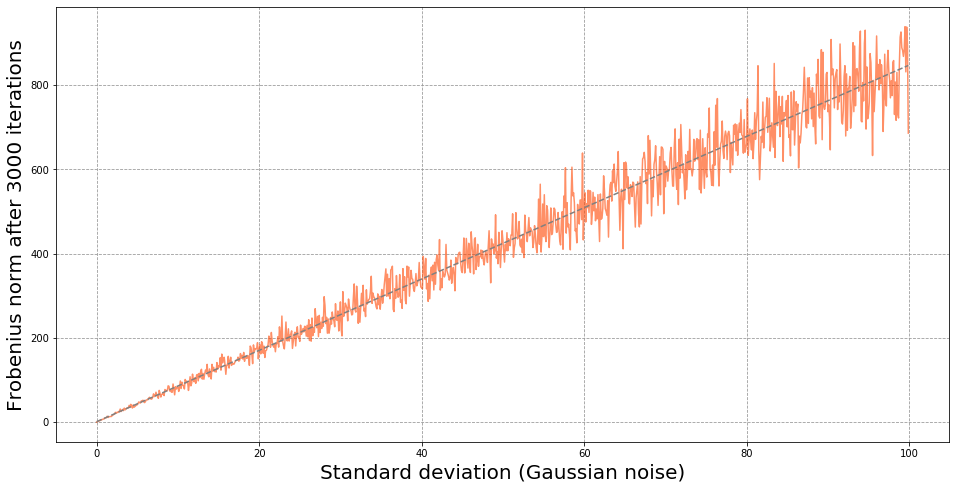

In [37]:
ys = [frob[i][-1] for i in range(n_models)]
xs = np.arange(n_models) * 0.1
plt.plot(xs, ys, color='orangered', alpha=0.6)
b, m = polyfit(xs, ys, 1)
xs = np.asarray([np.min(xs), np.max(xs)])
plt.plot(xs, b + m * xs, '--', color='grey')
plt.grid(b=True, which='major', color='#999999', linestyle='--')
plt.ylabel('Frobenius norm after 3000 iterations', fontsize=LABEL_FONT_SIZE)
plt.xlabel('Standard deviation (Gaussian noise)', fontsize=LABEL_FONT_SIZE)
plt.savefig('report/imgs/stdv.png')
plt.show()

## Convergence rate as a function of the forgetting factor

In [48]:
n = 10 # Number of inputs
m = 8 # Number of outputs

n_models = 1000

gen = Generator(n, m)

nus = np.linspace(0.5, 1.0, n_models)
models = [MultivariateLinearModel(n, m, nu=nus[i]) for i in range(n_models)]

states = [('mod%i' % (i + 1), 0, 0) for i in range(n_models)]

errors = [list() for _ in range(n_models)]
frob = [list() for _ in range(n_models)]
while True:
    x, y, counters = gen.sample(wscale=0.1)
    values = np.concatenate((counters, y, x))
    for i in range(n_models):
        state = models[i].update(values, states[i])
        errors[i].append(state[1])
        frob[i].append(np.sqrt((models[i]._beta - gen._beta.T) ** 2.).sum())
        states[i] = state
    
    if gen.counter >= 3000:
        break

In [49]:
def convergence_rate(ys):
    scaled = (ys - np.min(ys)) / (np.max(ys) - np.min(ys))
    return 1. - (np.trapz(scaled) / len(scaled))

In [51]:
conv_rates = np.asarray([convergence_rate(errors[i]) for i in range(n_models)])
conv_rates

[0.97400042 0.97397909 0.9739576  0.97393596 0.97391417 0.97389221
 0.9738701  0.97384784 0.97382543 0.97380286 0.97378013 0.97375726
 0.97373423 0.97371106 0.97368773 0.97366425 0.97364063 0.97361686
 0.97359293 0.97356886 0.97354465 0.97352028 0.97349577 0.97347112
 0.97344632 0.97342138 0.97339629 0.97337106 0.97334568 0.97332017
 0.97329451 0.97326871 0.97324277 0.97321668 0.97319046 0.9731641
 0.9731376  0.97311096 0.97308418 0.97305726 0.9730302  0.97300301
 0.97297568 0.97294822 0.97292062 0.97289288 0.97286501 0.972837
 0.97280886 0.97278058 0.97275217 0.97272363 0.97269495 0.97266614
 0.9726372  0.97260813 0.97257892 0.97254958 0.97252012 0.97249052
 0.97246079 0.97243093 0.97240094 0.97237082 0.97234057 0.9723102
 0.97227969 0.97224906 0.97221829 0.9721874  0.97215639 0.97212524
 0.97209397 0.97206257 0.97203105 0.9719994  0.97196762 0.97193572
 0.97190369 0.97187154 0.97183926 0.97180686 0.97177433 0.97174168
 0.97170891 0.97167601 0.97164298 0.97160984 0.97157657 0.97154318

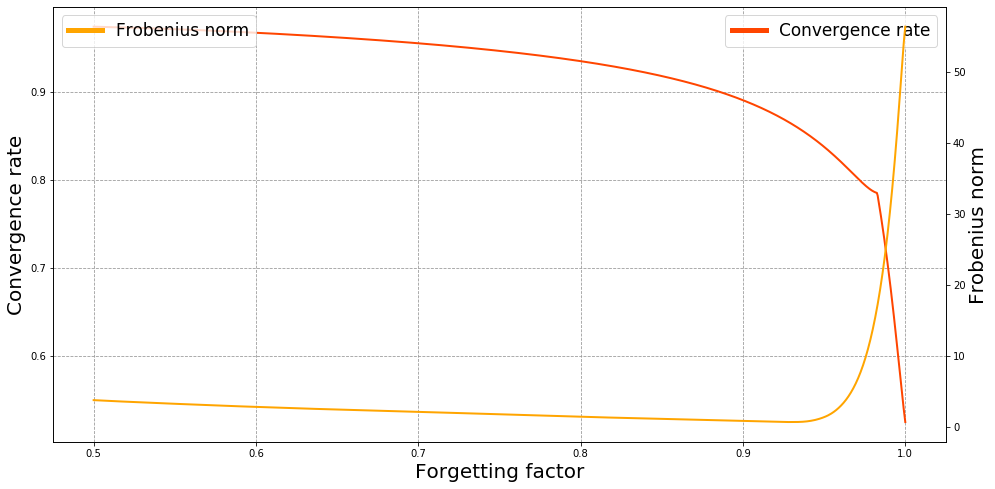

In [68]:
plt.rcParams["figure.figsize"] = (16, 8)

fig, ax1 = plt.subplots()
ax1.plot(nus, conv_rates, label='Convergence rate', color='orangered', linewidth=2)
plt.grid(b=True, which='major', color='#999999', linestyle='--')
ax1.set_ylabel('Convergence rate', fontsize=LABEL_FONT_SIZE)
ax1.set_xlabel('Forgetting factor', fontsize=LABEL_FONT_SIZE)
ax2 = ax1.twinx()
ax2.plot(nus, [frob[i][-1] for i in range(n_models)], label='Frobenius norm', color='orange', linewidth=2)
ax2.set_ylabel('Frobenius norm', fontsize=LABEL_FONT_SIZE)
leg = ax1.legend(prop={'size': 17})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
leg = ax2.legend(prop={'size':17})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.savefig('report/imgs/convergencerate.png')
plt.show()

In [21]:
def evaluate_forgetting_factor(nu):
    n, m = 10, 8
    gen = Generator(n, m)
    model = MultivariateLinearModel(n, m, nu=nu)

    state = ('mod', 0, 0)

    errors = list()
    frob = list()
    while True:
        x, y, counters = gen.sample(wscale=0.1)
        values = np.concatenate((counters, y, x))
        state = model.update(values, state)
        errors.append(state[1])
        frob.append(np.sqrt((model._beta - gen._beta.T) ** 2.).sum())

        if gen.counter >= 3000:
            break
    return frob[-1]

In [22]:
evaluate_forgetting_factor(0.95)

1.571700847446082

In [29]:
res = minimize_scalar(evaluate_forgetting_factor, method='bounded', bounds=(0.5, 1.0))

In [32]:
print('Optimal forgetting factor: %f' % res.x)

Optimal forgetting factor: 0.928970


## Frobenius norm as a function of the number of explanatory variables

In [15]:
m = 8 # Number of outputs

n_models = 80

errors = [list() for _ in range(n_models)]
frob = [list() for _ in range(n_models)]
for i in range(n_models):
    n = i + 1
    state = ('mod%i' % (i + 1), 0, 0)
    model = MultivariateLinearModel(n, m, nu=0.9)
    gen = Generator(n, m)
    while True:
        x, y, counters = gen.sample(wscale=0.1)
        if len(x.shape) == 0:
            x = np.asarray([x])
        values = np.concatenate((counters, y, x))
        state = model.update(values, state)
        errors[i].append(state[1])
        frob[i].append(np.sqrt((model._beta - gen._beta.T) ** 2.).sum())
    
        if gen.counter >= 3000:
            break

C:\Users\xanto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: covariance is not symmetric positive-semidefinite.


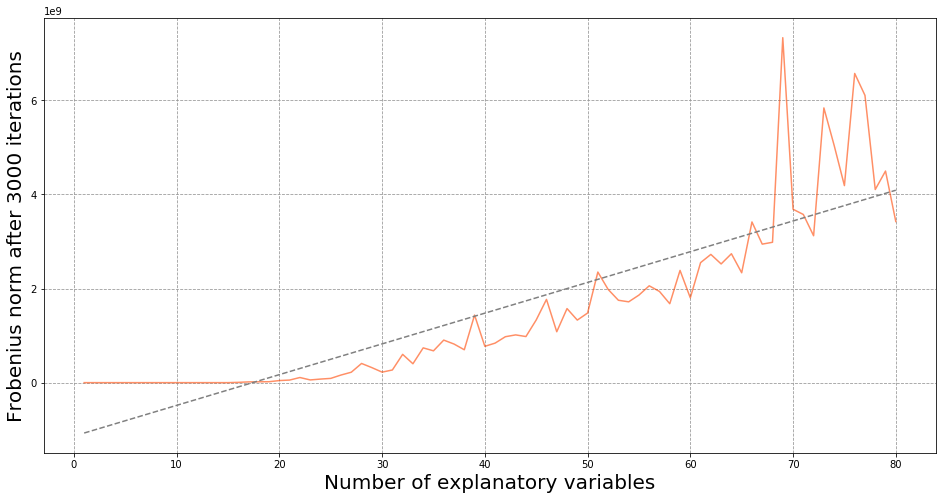

In [16]:
plt.rcParams["figure.figsize"] = (16, 8)
LABEL_FONT_SIZE = 20

ys = [frob[i][-1] for i in range(n_models)]
xs = np.arange(n_models) + 1
plt.plot(xs, ys, color='orangered', alpha=0.6)
b, m = polyfit(xs, ys, 1)
xs = np.asarray([np.min(xs), np.max(xs)])
plt.plot(xs, b + m * xs, '--', color='grey')
plt.grid(b=True, which='major', color='#999999', linestyle='--')
plt.ylabel('Frobenius norm after 3000 iterations', fontsize=LABEL_FONT_SIZE)
plt.xlabel('Number of explanatory variables', fontsize=LABEL_FONT_SIZE)
plt.savefig('report/imgs/ninputs.png')
plt.show()